# Desenvolvimento de um Sistema de Recuperação de Imagens Baseado em LBP e VGG16


### Desenvolvido por: Fernanda Paula Rocha

---

## Introdução

Este projeto tem como objetivo explorar técnicas de processamento de imagem para identificar obras de arte semelhantes com base em características de cor e textura, comparando duas técnicas. Parte desse projeto foi desenvolvido durante a disciplina Técnicas Avançadas para Captura e Tratamento de Dados pelos Prof.º Dr. Luis Gustavo Nonato e Moacir Ponti no MBA de Ciência de Dados do Centro de Pesquisa em Matemática Aplicada à Indústria (CeMEAI) do Instituto de Ciências Matemáticas e de Computação (ICMC) da Universidade Estadual de São Paulo (USP) de São Carlos. 

As duas técnicas utilizadas neste projeto são:

* O Local Binary Pattern (LBP) que é uma técnica de extração de características de textura que compara a intensidade de um pixel com seus vizinhos.

* O VGG16 que é uma arquitetura de rede neural convolucional profunda treinada no conjunto de dados ImageNet, capaz de extrair características visuais complexas. Ambos são usados para análise e classificação de imagens, mas o VGG16 pode capturar padrões mais complexos e abstratos do que o LBP.


## Descrição do Conjunto de Dados

O conjunto de dados utilizado neste projeto consiste em uma coleção de imagens de pinturas artísticas armazenadas no diretório "paintings22". Cada imagem representa uma obra de arte, e o objetivo é realizar uma busca por similaridade em relação a uma imagem de consulta específica, chamada "query.jpg". O conjunto de dados proporciona uma diversidade de estilos e autores, sendo um desafio desenvolver um sistema robusto de identificação. Isto é, comparar os resultados dos dois modelos de visão computacional, VGG16 e LBP, em termos de quão semelhantes são as imagens que eles recuperam para uma determinada imagem de consulta.


## Objetivo

O objetivo geral deste projeto é desenvolver um sistema eficaz de recuperação de imagens que possa encontrar imagens semelhantes a uma imagem de consulta. O sistema utiliza técnicas de processamento de imagens e aprendizado de máquina, incluindo o Local Binary Pattern (LBP) para extração de características de textura e o modelo VGG16 pré-treinado para extração de características visuais complexas.


# Mais informações 

Dada uma imagem `query.jpg` (presente no diretório paintings22) de uma pintura da qual não se sabe quem é o artista, deseja-se realizar uma busca em uma base de dados para recuperar obras similares. Para essa tarefa, emprega-se uma composição de características, que incluem:

1. **Cor:**
   - A imagem é convertida para um único canal de cor utilizando a fórmula: $I = R\cdot 0.299 + G\cdot0.587 + B\cdot 0.114$. Isso resulta em um único pixel $I$ para cada pixel RGB.
   - Posteriormente, é computado um histograma da imagem resultante com 18 bins, normalizando-o pela divisão pela soma dos valores.

2. **Textura:**
   - Utiliza-se o Local Binary Pattern (LBP) com raio 1.45 e 16 pontos, gerando um total de 18 características.

Os vetores de características resultantes desses dois processos são concatenados, formando um descritor que incorpora informações tanto de cor quanto de textura da imagem. Esse descritor é então utilizado para buscar as 5 imagens mais similares no diretório `paintings22`, considerando a distância L1 na comparação.

O resultado da busca é apresentado através da exibição da imagem de consulta, juntamente com as 5 imagens retornadas, incluindo seus nomes e os valores das distâncias L1 obtidas. Esse processo visa identificar obras de arte visualmente similares à imagem de consulta, mesmo quando o autor da obra é desconhecido.

# ----------------------------------------------------------------------
# Carregamento e Pré-processamento de Imagens
# ----------------------------------------------------------------------

In [1]:
# --------------------------------------------------------------
# Importação de Bibliotecas
# --------------------------------------------------------------

import os
import re
import string
# import nltk
import imageio
import pandas as pd
# import requests as rq
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image


# from urllib import request
# from bs4 import BeautifulSoup
# from nltk import word_tokenize

from tensorflow.keras.preprocessing import image
from os import listdir, path
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from skimage import io
from skimage import feature
from skimage.io import imread_collection


# from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------------
# Carregamento e Exploração Inicial dos Dados
# ------------------------------------------------------------------

###  Calculando o histograma global de intensidade de uma imagem colorida

A função ``histograma_global_intensity`` recebe uma imagem colorida, converte-a para escala de cinza ponderada e calcula o histograma global de intensidade, normalizando-o antes de retornar. Essa abordagem permite que a imagem de consulta seja representada de forma mais abrangente, incorporando características tanto de cor quanto de textura. Esses descritores combinados serão valiosos para a busca efetiva de imagens similares no contexto do projeto.

In [2]:
def histograma_global_intensity(img):
    #ncolors = 18
    img_int = img[:,:,0].astype(float)*0.299 + img[:,:,1].astype(float)*0.587 + img[:,:,2].astype(float)*0.114
    hist,_ = np.histogram(img_int, bins= 18)
    # normaliza o vetor resultante pela soma dos valores
    hist = hist.astype("float")
    hist /= (hist.sum() + 0.0001)        
    return hist

### Calculando o histograma dos padrões binários locais (Local Binary Patterns - LBP) de uma imagem

Essa função é útil para extrair características de textura da imagem, que podem ser combinadas com o descritor de cor (por exemplo, histograma de intensidade) para formar um descritor completo e robusto para a busca por similaridade no projeto.


In [3]:
def lbp_features(img):
    
    points=16
    radius=1.45
    n_bins=18
    
    # LBP opera em imagens de um só canal, aqui vamos converter 
    # RGB para escala de cinza usando o método Luminance
    img = np.array(img, dtype=np.float64, copy=False)
    if (len(img.shape) > 2):
        img = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114
    
    # normaliza a imagem para ter máximo = 255
    if (np.max(img) > 0):
        img = ((img/np.max(img))*255).astype(np.uint8)
    
    # aqui definimos o numero de pontos e o raio, padrao = 8, 1
    lbp = feature.local_binary_pattern(img.astype(np.uint8), points, radius, method="uniform")
    
    # lbp retorna um matriz com os códigos, então devemos extraír o histograma
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins+1), range=(0, n_bins))

    # normaliza o histograma
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns

    return hist

## Aplicando Local Binary Pattern (LBP)

O Local Binary Pattern (LBP) é utilizado para extrair características das imagens e, em seguida, calcula-se a distância entre as características da imagem de consulta (query) e as características de cada imagem na base de dados. 

### Carregando imagens

In [4]:
# Carregando o banco de imagens
lista_imagens = os.listdir("paintings22/")

# Carregando somente a imagem de consulta
query = imageio.imread("./paintings22/query.jpg")

# Calculando o vetor da imagem query.jpg
hist_query = histograma_global_intensity(query)
lbp_query = lbp_features(query)

# concatenando os resultados da imagem query.jpg
concat_query = np.concatenate([hist_query, lbp_query])

In [5]:
# Carregando todas as imagens
imagens = []
for i in os.listdir("paintings22/"):
    imagens.append(imageio.imread(f"paintings22/{i}"))

### Criando um conjunto de características (features) para cada imagem presente na lista imagens

In [6]:
features = []

# Aplicando os descritores de cor e textura em cada imagem
for img in imagens:
    # funções dos descritores 
    hist = histograma_global_intensity(img)
    lbp = lbp_features(img)
    # concatenando os resultados das imagens
    concat = np.concatenate([hist, lbp])

    features.append(concat)

In [7]:
# Calculando a distância da imagem de consulta para as demais do banco de imagens
dist = np.zeros(40)
for i in range(40):
    dist[i] = np.sum((np.abs(concat_query-features[i])))

In [8]:
sorted_indices = np.argsort(dist)

In [9]:
# sorted_indices = sorted(dist)

In [10]:
diretorio_imagens = "paintings22/"

image_filenames = []

for filename in os.listdir(diretorio_imagens):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_filenames.append(filename)


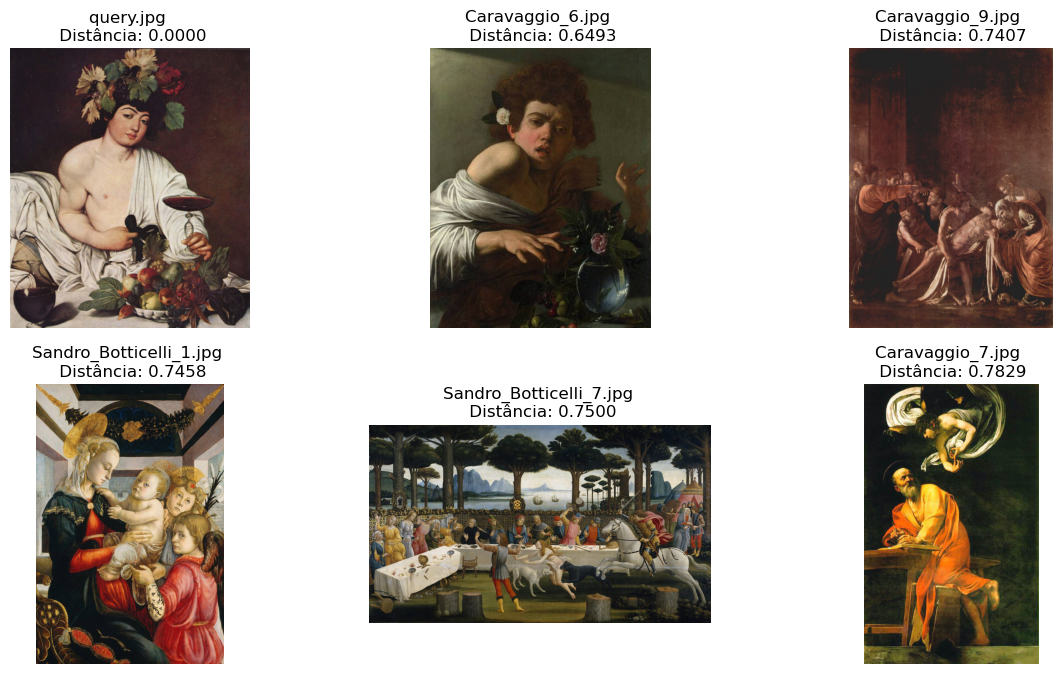

In [11]:
# plotar as imagens
plt.figure(figsize=(15,8))
num_images = 6
for i in range(num_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(imagens[sorted_indices[i]])
    image_filename = image_filenames[sorted_indices[i]]
    plt.title(f"{image_filename} \n Distância: {dist[sorted_indices[i]]:.4f}")
    plt.axis('off')
plt.show()

## Aplicando o modelo VGG16 pré-treinado

In [12]:
# Modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Carregando imagem de consulta
query_img_path = 'paintings22/query.jpg'
img = image.load_img(query_img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Obtendo representação de características da imagem de consulta
query_features = model.predict(img_array)

# Iterando sobre a base de dados e calcular similaridade
base_dir = 'paintings22/'
similar_images = []

for filename in os.listdir(base_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(base_dir, filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        features = model.predict(img_array)
        similarity = cosine_similarity(query_features, features)[0][0]

        similar_images.append((img_path, similarity))

# Ordenando as imagens por similaridade
similar_images.sort(key=lambda x: x[1], reverse=True)

N = 5
for i in range(N):
    print(f"Similaridade {i + 1}: {similar_images[i][1]} - Imagem: {similar_images[i][0]}")


1/1 [==============================] - 1s 526ms/step
Similaridade 1: 1.0000001192092896 - Imagem: paintings22/query.jpg
Similaridade 2: 0.6593857407569885 - Imagem: paintings22/Caravaggio_6.jpg
Similaridade 3: 0.4988182485103607 - Imagem: paintings22/Caravaggio_7.jpg
Similaridade 4: 0.48208996653556824 - Imagem: paintings22/Caravaggio_2.jpg
Similaridade 5: 0.44248560070991516 - Imagem: paintings22/Caravaggio_4.jpg


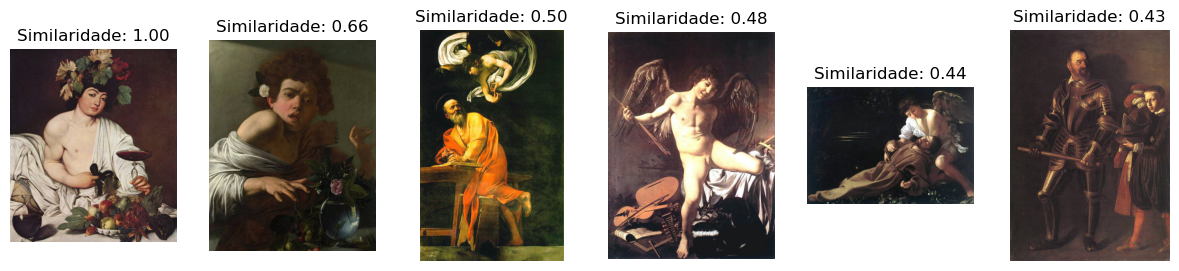

In [13]:
N = 6

# Plotar as imagens
fig, axes = plt.subplots(1, N, figsize=(15, 3))

for i in range(N):
    img_path = similar_images[i][0]
    similarity = similar_images[i][1]
    
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Similaridade: {similarity:.2f}")
    axes[i].axis('off')

plt.show()

# ------------------------------------------------------------------
# Conclusão Geral
# ------------------------------------------------------------------

Ambos os modelos selecionaram a mesma imagem como a mais semelhante à imagem de referência. No entanto, suas escolhas secundárias divergiram, evidenciando abordagens distintas na análise de imagens.

O VGG16, um modelo de aprendizado profundo, foca em características complexas e abstratas, destacando elementos além das texturas locais. Em contraste, o LBP, um método mais simples para análise de textura, concentra-se em estruturas locais, sendo altamente sensível a texturas específicas.

Essas diferenças fundamentais nas abordagens podem explicar as disparidades nos resultados, já que cada modelo atribui importância a características que o outro desconsidera. Apesar dessas distinções, é notável que ambos os modelos identificaram a mesma imagem como a mais semelhante, demonstrando concordância na identificação da imagem de referência.

Devido a demora na simulação do VGG16, pode ser benéfico, dependendo do objetivo, utilizar o LBP. 

# -------------------------------------------------------------------------
# Possíveis estratégias para melhorar os resultados
# -------------------------------------------------------------------------

1. **Aumento de Dados (Data Augmentation):**
   - Aplicar técnicas de aumento de dados para diversificar o conjunto de treinamento. Isso pode ajudar os modelos a generalizarem melhor para uma variedade maior de padrões.


2. **Ajuste Fino (Fine-Tuning):**
   - Realizar ajuste fino nos modelos pré-treinados para adaptá-los especificamente à tarefa em questão. Isso é especialmente eficaz quando se utiliza modelos pré-treinados em conjuntos de dados semelhantes.


3. **Análise dos Erros:**
   - Analisar os erros cometidos pelos modelos para entender padrões específicos que podem estar causando divergências. Isso pode fornecer insights valiosos para ajustar as estratégias de treinamento.


4. **Avaliação com Métricas:**
   - Considerar métricas de avaliação mais específicas para a tarefa em questão. Algumas métricas podem destacar melhor as diferenças entre as escolhas dos modelos.


5. **Experimentação com Arquiteturas Alternativas:**
   - Explore arquiteturas de modelos alternativas que possam se destacar na tarefa específica, levando em consideração as características do conjunto de dados.

6. **Refinamento de Parâmetros:**
    - Realize uma busca sistemática de hiperparâmetros para otimizar a configuração do modelo em relação à tarefa específica.


# -------------------------------------------------------------------------
# Referências
# -------------------------------------------------------------------------

**Dataset**
1. Esses dados foram disponibilizados pelos professores da disciplina. 

**Livros**

1. Sheryl Brahnam, Lakhmi C. Jain, Loris Nanni, Alessandra Lumini. Local Binary Patterns: New Variants and Applications. Springer, 2014. Disponível em: https://doi.org/10.1007/978-3-642-39289-4


2. Karen Simonyan and Andrew Zisserman. Very Deep Convolutional Networks for Large-Scale Image Recognition. ArXiv, 2014. Disponível em: https://doi.org/10.48550/arXiv.1409.1556

Mais informações do algoritmo VGG16 disponíveis em: https://keras.io/api/applications/vgg/

